In [1]:
import numpy as np
from matplotlib import pyplot as plt

* Given references
  * $R_1 = (x_1, y_1)$,
  * $R_2 = (x_2, y_2)$,
  * $R_3 = (x_3, y_3)$,
  * $R_4 = (x_4, y_4)$, and
  * $R_5 = (x_5, y_5)$,

Find position of $Z = (x, y)$ for $Z$ seeing the signal strength from $R_1$ to $R_5$ as
$S_1$ to $S_5$.




# Test case

In [2]:
Ref = np.array([[100, 0], [100, 100], [0, 100],
       [0, 0], [-20, 50]])

# The ground-truth position of the device
Zgt = np.array((30, 70)).reshape((1,2))

# The distance
D = np.sqrt(np.sum( (Ref - Zgt)**2, axis = 1 ))

D



array([98.99494937, 76.15773106, 42.42640687, 76.15773106, 53.85164807])

In [3]:
# Signal strength is proposional to the distance

S = 1/D**2

S

array([0.00010204, 0.00017241, 0.00055556, 0.00017241, 0.00034483])

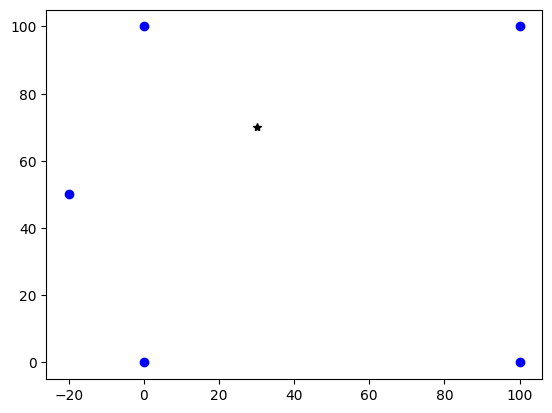

In [4]:
plt.plot(Ref[:,0], Ref[:,1], 'bo')

plt.plot(Zgt[0, 0], Zgt[0,1], 'k*')


## Solution: weighed average using distance as weight

In [5]:
eD = 1/np.sqrt(S)
eD

array([98.99494937, 76.15773106, 42.42640687, 76.15773106, 53.85164807])

In [6]:
w = S
w = w/np.sum(w)

In [7]:
eZ = np.mean( w.reshape((-1, 1)) * Ref, axis =0 )

In [8]:
eZ

array([ 3.05049333, 13.36622171])

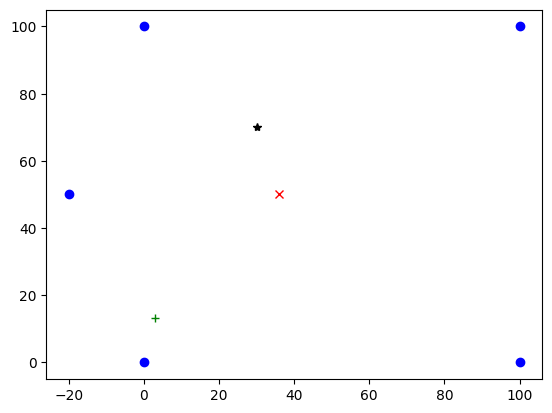

In [9]:
ref_bar = np.mean(Ref, axis=0)

plt.plot(Ref[:,0], Ref[:,1], 'bo')

plt.plot(Zgt[0,0], Zgt[0,1], 'k*')
plt.plot(ref_bar[0], ref_bar[1], 'rx')

plt.plot(eZ[0], eZ[1], 'g+')

Simply weighted average does not work!

Triangulation

* For reference $R_i = (x_i, y_i)$, distance to the unknown point
  * $d_i^2 = (x_i - x)^2 + (y_i - y)^2$

* Frame it as optimization.

$\min_{x, y} \sum_i ((x_i - x)^2 + (y_i - y)^2 - d_i^2)^2$

Loss $L = \sum_i ((x_i - x)^2 + (y_i - y)^2 - d_i^2)^2$

In [10]:
def tloss(P, Rs, Ds):
    '''
    P : unknown position, np.array (1, 2)
    Rs: reference positions, np.array (N, 2)
    Ds: distances from the uknown position to references, np.array (N, 1)
    '''

    C = np.sum( (Rs - P)**2, axis=1).reshape((-1,1)) - Ds**2
    loss = np.sum(C**2)
    return loss


a = tloss(Zgt, Ref, eD.reshape((-1,1)))
a

1.5561335273653833e-23

Gradient

\begin{align}
\nabla_{x, y} L &=&
\begin{bmatrix}
\frac{\partial L}{\partial x}
\\
\frac{\partial L}{\partial y}
\end{bmatrix}
\\
&=&
-4
\begin{bmatrix}
\sum_i ( (x_i - x)^2 + (y_i - y)^2 - d_i^2  ) \cdot (x_i - x) \\
\sum_i ( (x_i - x)^2 + (y_i - y)^2 - d_i^2  ) \cdot (y_i - y)
\end{bmatrix}
\end{align}

In [11]:
def tgrad(P, Rs, Ds):
    '''
    P : unknown position, np.array (1, 2)
    Rs: reference positions, np.array (N, 2)
    Ds: distances from the uknown position to references, np.array (N, 1)
    '''

    diff = Rs - P            # N x 2

    C1 = np.sum( diff**2, axis=1).reshape((-1,1)) - Ds**2  # N x 1
    C2 = np.multiply(diff, C1)   # N x 2
    dL = -4*np.sum(C2, axis=0).reshape((1, 2))
    return dL

a = tgrad(eZ, Ref, eD.reshape((-1,1)))
a

array([[-4313610.15181475, -5989974.90052387]])

In [12]:
eD.shape

(5,)

In [14]:
def gdl(grad_loss , w0, step_size , num=500, lossf=None):
    w = w0
    if lossf is not None:
        losses = [lossf(w)]

    for i in range(num):
        w = w - step_size * grad_loss(w)

        if lossf is not None:
            losses.append(lossf(w))

    if lossf is None:
        return w
    else:
        return w, losses

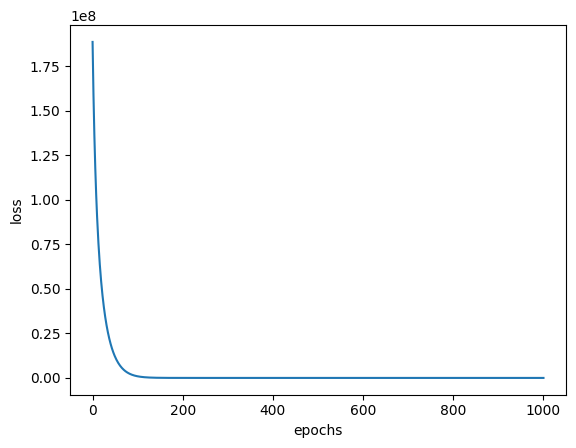


Minimizer = [[30. 70.]]
loss = 2.995325843197154e-17


In [15]:
E = lambda P: tloss(P, Ref, eD.reshape((-1,1)))
dE = lambda P: tgrad(P, Ref, eD.reshape((-1,1)))

w0 = np.mean( w.reshape((-1, 1)) * Ref, axis =0 ) # Initialize with average
w0 = w0.reshape((1,2))
lr = 0.0000003
N = 1000
wgd, losses = gdl(dE, w0, lr, N, E)

plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

print('\nMinimizer =', wgd)
print('loss =', losses[-1])

The answer is (30, 70), which is correct!!!

# End appendix